In [5]:
%load_ext autoreload
%autoreload 2

from datasets.clock import ClockConfig, ClockDatasetConfig
from datasets.clock import get_dataloaders
from autoencoder.vis import load_model_script, load_model_state_dict, visualize_latent, visualize_predictions, visualize_reconstruction, print_model_parameters, show_data
from autoencoder.clock import eval_model
from models.autoencoders import MLPResnetAutoencoder
import torch
import torch.nn as nn
import sys
import os
import numpy as np
import functools

from models.encoders import ConvMLPEncoder

sys.path.append(os.path.join(os.getcwd(), '..'))

device = "cuda" if torch.cuda.is_available() else "cpu"


# def hand_width_scheduler(idx, alpha=1e-3):
#   """
#   Returns a value for hand width, ranging from ~0.2 to ~0.05
#   alpha: how fast the hand width decreases
#   """
#   mean = -3 * torch.tensor(idx*alpha).sigmoid()
#   return np.random.lognormal(mean, 0.01)

IMG_SIZE=64
BATCH_SIZE=128

dataloader, val_dataloader, _, _ = get_dataloaders(
  data_config=ClockConfig(
    hour_hand_width=0.1,
    minute_hand_width=0.075,
    minute_hand_start=1/3,
  ),
  dataset_config=ClockDatasetConfig(
      data_size=2**24,
      augment=dict(
        noise_std=0.01,
      ),
      img_size=64,
    ),
  batch_size=BATCH_SIZE,
)

LATENT_DIM=2
type_ = "autoencoder"
load_model_checkpoint = functools.partial(
  load_model_state_dict, 
  model_class=MLPResnetAutoencoder, 
  img_size=IMG_SIZE, 
  latent_dim=LATENT_DIM, 
  name="MLPResnetAutoencoder", 
  postfix="d24",
)

model = load_model_checkpoint(checkpoint=0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print_model_parameters(functools.partial(load_model_checkpoint, checkpoint=0))

Layer                                       Param Count
------------------------------------------------------------
------------------------------------------------------------
Total Trainable Parameters                      839,895


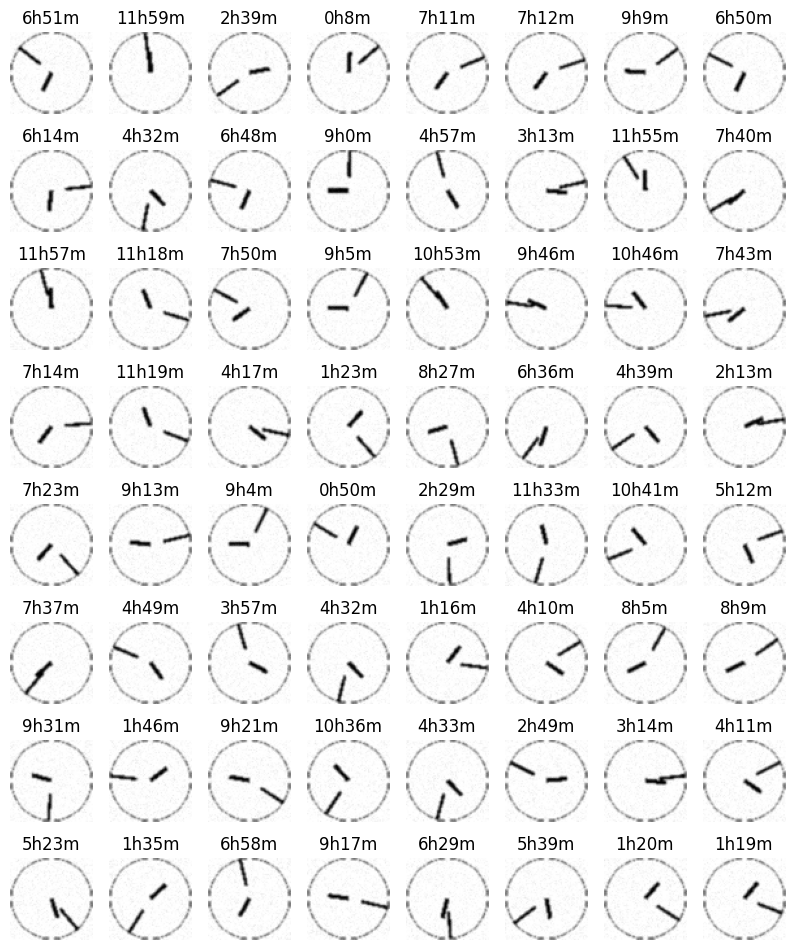

In [3]:
for i in range(1):
  show_data(dataloader)

In [12]:
model = load_model_checkpoint(checkpoint=8)
eval_model(type_, model, [i for i in val_dataloader], device=device, latent_dim=LATENT_DIM, criterion=nn.SmoothL1Loss())

0.0034102999488823116

: 

# Encoders

In [5]:
visualize_predictions(type_, model, dataloader, latent_dim=LATENT_DIM)

Not encoder


In [6]:
# for i in range(16):
#   model = load_model_checkpoint(checkpoint=i)
#   visualize_latent(type_, model, latent_dim=LATENT_DIM, dataloader=dataloader)


# Decoders

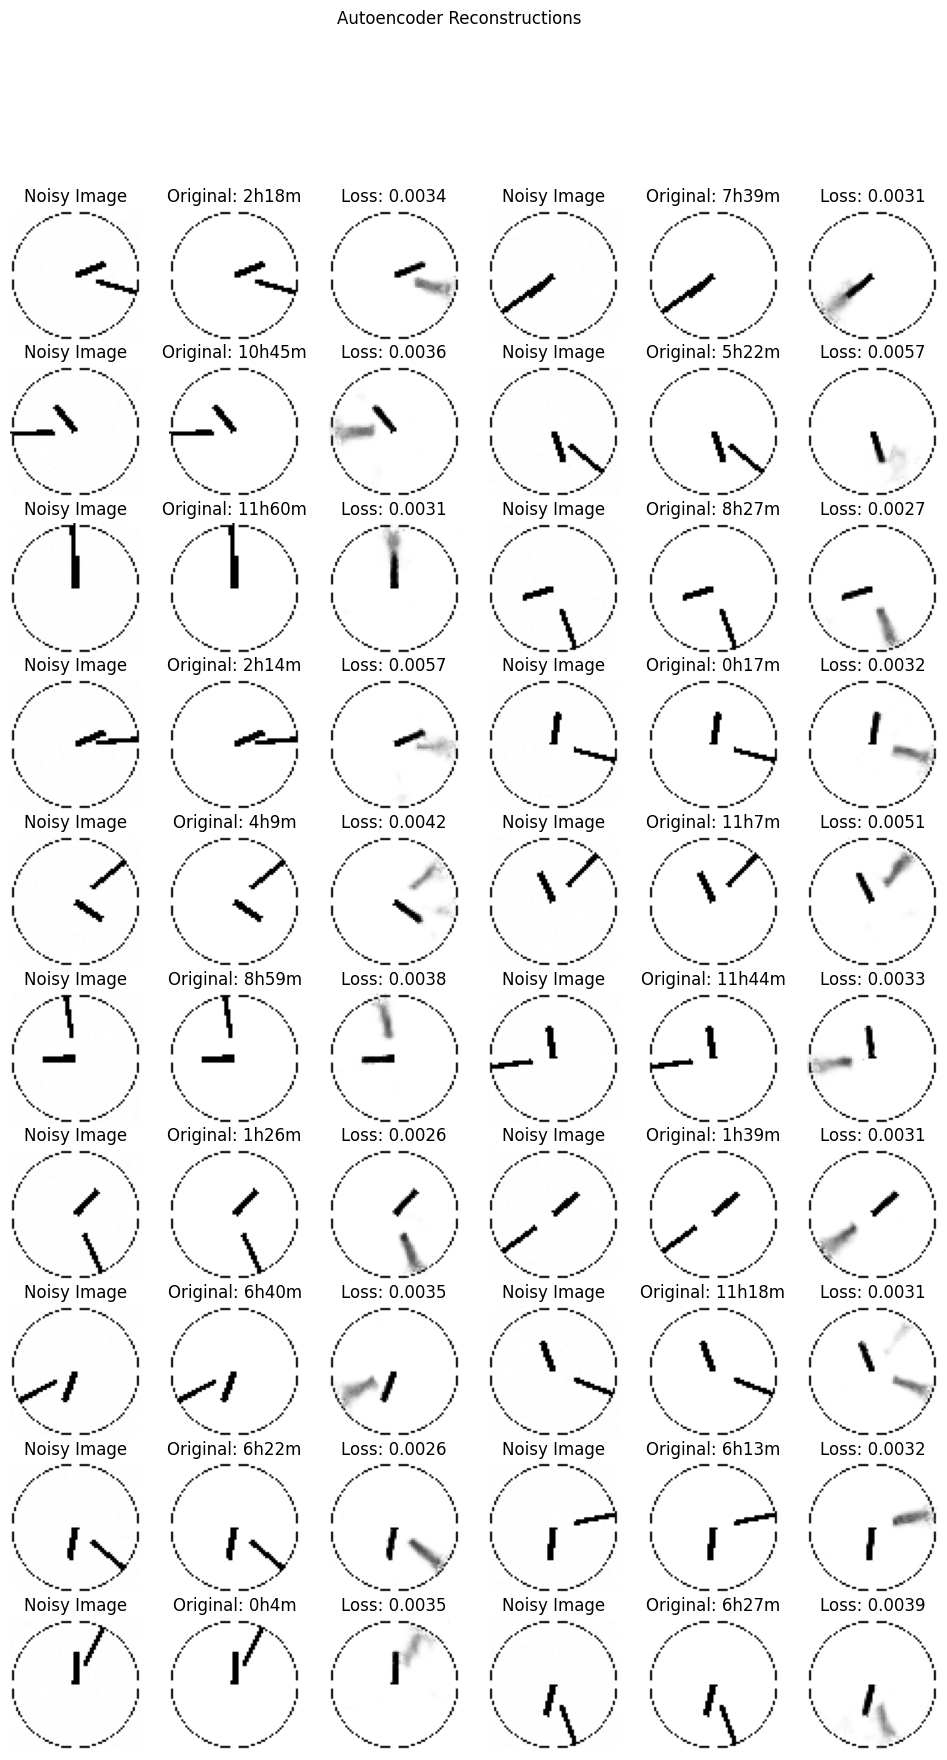

In [10]:
model = load_model_checkpoint(checkpoint=7)
visualize_reconstruction(type_, model, dataloader, latent_dim=LATENT_DIM)

# Autoencoders

 50%|█████     | 8/16 [00:16<00:16,  2.00s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/MLPResnetAutoencoder/2-i64-d24/8.pt'

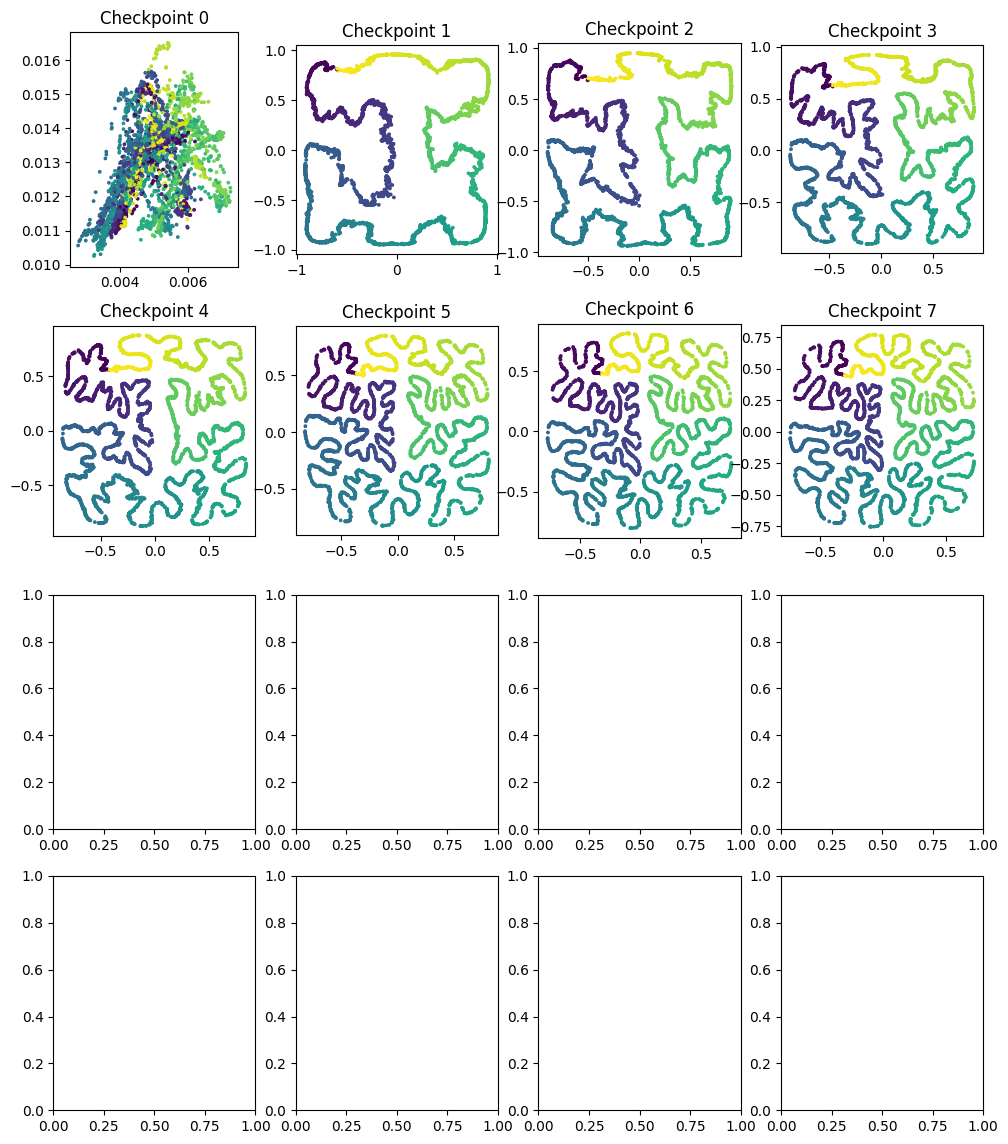

In [9]:
import json
from autoencoder.vis import load_model_state_dict, get_outputs
from datasets.clock import get_dataloaders
from datasets.clock import ClockConfig, ClockDatasetConfig
from models.autoencoders import MLPResnetAutoencoder
import matplotlib.pyplot as plt
import torch
import numpy as n
from tqdm import tqdm
from sklearn.decomposition import PCA

fig, ax = plt.subplots(4, 4, figsize=(12, 14))

for i in tqdm(range(16)):
  model = load_model_checkpoint(checkpoint=i)
  
  latents = []
  labels1d = []
  for _, _, label1d, _, latent, _ in get_outputs(type_, model, dataloader, limit=4096):
    latents.append(latent.unsqueeze(0).cpu())
    labels1d.append(label1d.unsqueeze(0).cpu())
    
  latents = torch.cat(latents, dim=0)
  labels1d = torch.cat(labels1d, dim=0)
  
  if LATENT_DIM > 2:
    pca = PCA(n_components=2)
    latents = pca.fit_transform(latents)
  
  ax[i//4, i%4].scatter(latents[:, 0], latents[:, 1], c=labels1d, cmap="viridis", s=3)
  ax[i//4, i%4].set_title(f"Checkpoint {i}")
  ax[i//4, i%4].set_aspect('equal', adjustable='box')
  
plt.suptitle("Latent Space Visualization at Different Checkpoints")
plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()
